In [1]:
import glob  # for file management
from skimage import io, morphology, measure # for reading in the tif image stacks, dilation
from skimage.filters import threshold_otsu
from scipy import ndimage, datasets # for manipulating the tif image stacks
import matplotlib.pyplot as plt # for plotting
from matplotlib.colors import LogNorm, Normalize
import numpy as np # for manipulating image matrices
import numpy.ma as ma
from scipy.stats import norm, lognorm
import seaborn as sns # for plotting
from fitter import Fitter, get_common_distributions, get_distributions
import tifffile
import time
import scipy

### Required Functions

The following cell defines all the functions that will be used and needs to be run first

In [2]:
def read_tiff_voxel_size(file_path):
    """
    Implemented based on information found in https://pypi.org/project/tifffile
    """

    def _xy_voxel_size(tags, key):
        assert key in ['XResolution', 'YResolution']
        if key in tags:
            num_pixels, units = tags[key].value
            return units / num_pixels
        # return default
        return 0.07

    with tifffile.TiffFile(file_path) as tiff:
        image_metadata = tiff.imagej_metadata
        if image_metadata is not None:
            z = image_metadata.get('spacing', 1.)
        else:
            # default voxel size
            z = 0.07

        tags = tiff.pages[0].tags
        # parse X, Y resolution
        y = _xy_voxel_size(tags, 'YResolution')
        x = _xy_voxel_size(tags, 'XResolution')
        
        # return voxel size
        return [z, y, x]
    
def isolate_cell(input_img_stack):
    '''
    Inputs:
        input_img_stack:  numpy matrix with shape (n, N, M), 
                          where n=number of frames in the image stack, and NxM is the shape of each image in the stack
                          
    Outputs:
        img_stack_no_bg:    numpy matrix same shape as the input with the background zeroed out
        img_stack_only_bg:  numpy matrix same shape as the input with the cell region zeroed out
    
    '''
    # Maximum intensity projection
    mipmask = np.max(input_img_stack, axis=0)

    # Otsu method of thresholding
    thresh = threshold_otsu(mipmask)
    # Create binary mask of thresholded image
    bint = mipmask > thresh

    # dilation of binary image
    dia = morphology.diamond(radius=12)
    dilt = morphology.binary_dilation(bint, dia)

    # find all connected components in the image
    labeled_image, count = measure.label(dilt, return_num=True)
    labels = measure.label(dilt)

    # Identify the cell by getting largest segment identified by the connected components
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=dilt.flat))

    # Identify the background
    img_stack_only_bg = input_img_stack.copy()
    for ii in range(0, len(img_stack_only_bg), 1):
        img_stack_only_bg[ii][largestCC] = 0 # zero out the cell for all frames        

    # Zero out regions not identified as part of the cell
    img_stack_no_bg = input_img_stack.copy()
    for ii in range(0, len(img_stack_no_bg), 1):
        img_stack_no_bg[ii][~largestCC] = 0 # zero out the background for all frames
        
    return img_stack_no_bg, img_stack_only_bg

def apply_mask_from_file(input_image, mask_filename, filename_shorthand=None, channels=1):
        '''
        Input:
            input_image:        a numpy matrix; contains the stacked science image 
            mask_filename:      a string; filepath to the masked TIF file
            filename_shorthand: a string; to be used for printing purposes
            
        Output:
            result: numpy array containing the masked science image
            
        Assumptions:
            the science image (numpy matrix) is assumed to originate from a video TIF file; 
                for nframes of a video, each frame of size NxM results in a numpy matrix of shape (nframes, N, M)
            the masked TIF file and each frame of the science TIF stack are required to be the same size
        '''
        
        # get shorthand filename
        if filename_shorthand is None:
            mask_fname = mask_filename
        else:
            mask_fname = filename_shorthand
        print('\n  mask fname:', mask_fname)

        # read the image stack
        mask_img = io.imread(mask_filename) # for reading the TIF files
        
        if len(mask_img.shape) > 2:
            channels = mask_img.shape[2]
        
        if channels > 1:
            mask_img = mask_img[:,:,0]
            mask_img[mask_img!=255] = 0
            mask_img[mask_img==255] = 1
        else:
            mask_img[mask_img!=255] = 1
            mask_img[mask_img==255] = 0

        # size of each image in video
        width = mask_img.shape[0]
        height = mask_img.shape[1]
        
        print('\tmasked image shape: %i x %i' %(width, height))
        cell_size = np.nansum(mask_img)
        print("\tmasked cell size (num pixels):", np.nansum(mask_img))
                
        # apply the mask to the image stack, label final result as "result"
        result = np.zeros(input_image.shape, dtype="float")
        for ii in range(0, len(result), 1):
            result[ii] = np.multiply(input_image[ii], mask_img)    
            
        return result, cell_size
    
def compute_img_stats_per_pixel(input_img):
    
    #Compute the mean at each pixel location
    mean_img = np.mean(input_img, axis=0)

    #Compute the mean at each pixel location
    median_img = np.median(input_img, axis=0)

    # Compute the standard deviation at each pixel location
    std_img = np.std(input_img, axis=0)

    # Compute the standard deviation at each pixel location
    var_img = np.var(input_img, axis=0)
    
    return mean_img, median_img, std_img, var_img

def compute_total_img_stats(input_img):

    mean_img, median_img, std_img, var_img = compute_img_stats_per_pixel(input_img)

    # Compute mean/median/stddev of the cell overall
    tot_means = []; tot_medians = []; tot_stds = []; tot_vars = []
    for ii in range(0, len(input_img), 1):
        tot_means.append(np.mean(input_img[ii][input_img[ii]!=0]))
        tot_medians.append(np.median(input_img[ii][input_img[ii]!=0]))
        tot_stds.append(np.std(input_img[ii][input_img[ii]!=0]))
        tot_vars.append(np.var(input_img[ii][input_img[ii]!=0]))
    tot_mean = np.mean(tot_means)
    tot_median = np.median(tot_means)
    tot_std = np.std(tot_stds)
    tot_var = np.var(tot_stds)

    return tot_mean, tot_median, tot_std, tot_var

def find_num_flashes_img(input_img, nstd=3.0):
    '''
    Produces an nframes x image (2D array): 
        each entry/pixel location contains a 1 or 0
        corresponding to whether that position has a flash above nstd above the median
    '''
        
    _, median_img, std_img, _ = compute_img_stats_per_pixel(input_img)
    
    # create a matrix the same size as the image filled with zeros
    nstd_above_median_flashes = np.zeros(input_img.shape, dtype="int")

    for ii in range(0, len(input_img), 1):

        # define threshold as nstd above the median
        num_std = input_img[ii] - (median_img + nstd*std_img)
        
        # find all regions above the threshold
        i = np.where(num_std > 0)
        
        # fill in the locations where a pixel has "flashed" 
        nstd_above_median_flashes[ii][i] = 1
        
    return nstd_above_median_flashes

def filter_local_flashes(input_img):
        
    new_img = np.zeros(input_img.shape, dtype="int") 
    
    for frame in range(0, len(input_img), 1):
        
        objects = measure.label(input_img[frame])

        # Separate objects into regions larger than 10 pixels
        large_objects = morphology.remove_small_objects(objects, min_size=4, connectivity=2)
        largest_objs = large_objects > 0
        
        new_img[frame][largest_objs] = 1
    
    return new_img

def find_num_pixel_flashes(input_img, nstd=3.0):
    '''
    Produces a summary image (2D array):
        Computes the sum of the find_num_flashes_img output
    '''
    
    nstd_above_median_flashes = find_num_flashes_img(input_img, nstd=nstd)
    filtered_nstd_above_median_flashes = filter_local_flashes(nstd_above_median_flashes)
    
    num_flashes_above_nstd = np.sum(filtered_nstd_above_median_flashes, axis=0)
    
    return num_flashes_above_nstd

def freq_of_flashes(input_img, nstd=3.0):
    '''
    Produces a summary image (2D array):
        each entry/pixel location contains an integer number
        corresponding to the number of UNIQUE times that a position has a flash above nstd above the median
        "unique" here refers to the each initial time that a pixel rises above nstd above the median after being below nstd
        but does not double count (e.g., if that pixel remains above nstd, then that is considered part of the same flash)
    '''
           
    nstd_above_median_flashes = find_num_flashes_img(input_img, nstd=nstd)
    
    # remove isolated flashes
    filtered_nstd_above_median_flashes = filter_local_flashes(nstd_above_median_flashes)
    
    # create a matrix the same size as the image filled with zeros
    freqs = np.zeros((input_img.shape[1], input_img.shape[2]), dtype="int")

    for ii in range(1, len(filtered_nstd_above_median_flashes), 1):

        # compare whether a flash occurred in the current frame versus the last frame in the video
        # if current - last = 1 - 0 = 1, then a flash just started
        # if current - last = 1 - 1 or 0 - 0 = 0, then there has been no change
        # if current - last = 0 - 1 = -1, then a flash just stopped
        changes = filtered_nstd_above_median_flashes[ii] - filtered_nstd_above_median_flashes[ii-1]
        
        # find all regions for which current - last = 1; i.e., a flash has started
        i = np.where(changes > 0)
        
        # tally the regions where a flash started 
        freqs[i] += 1
        
    return freqs

def scale_freq_flashes(freqs, nframes=10, pixel_size=0.07, num_pixels=1000, nstd=1.0, silence=False):
    '''
    Scale the total number of unique flashes to a percent area that flashes

    '''
#     mean_flashes_freq = np.mean(freqs[freqs > 0])
#     mean_flashes_freq_scaled = (mean_flashes_freq * pixel_size * pixel_size) / (num_pixels * nframes)

    # Average Flashing Area Per Frame: Sum(flashes) * (Area of a pixel) / (Number of frames)
    total = np.sum(freqs[freqs > 0])
    avg_area = (total * pixel_size * pixel_size) / nframes
    
    # scale by the region size
    avg_area_scaled = avg_area / num_pixels
    
    # Area of the region (size of total possible flashing area)
    area_of_region = num_pixels * pixel_size * pixel_size
    
    # Percentage of the cell that flashes per frame: 100 x (Avg Flashing Area Per Frame) / (Area of the region)
    percent_of_cell_that_flashes = 100.0 * total / (nframes * num_pixels)
    
    if not silence:
#         print('  Mean Frequency of Flashes per location (%s-sig):\n\t\t%s' %(str(nstd),str(mean_flashes_freq)))
#         print('  Mean Frequecy of Flashes per location Scaled (%s-sig):\n\t\t%s' %(str(nstd),str(mean_flashes_freq_scaled)))
        print('  Avg Flashing Area per Frame, (Unique Flashes) (%s-sig):\n\t\t%s' %(str(nstd),str(avg_area)))
        print('  Area of total possible flashing region (%s-sig):\n\t\t%s' %(str(nstd),str(area_of_region)))
        print('  Percentage of Cell that Flashes per Frame (Unique Flashes) (%s-sig):\n\t\t%s' %(str(nstd),str(percent_of_cell_that_flashes)))
    
    return total, avg_area, avg_area_scaled, percent_of_cell_that_flashes

def scale_num_pixel_flashes(num_flashes_above_nstd, nframes=10, pixel_size=0.07, num_pixels=1000, nstd=1.0, silence=False):
    '''
        num_flashes_above_nstd: count of the number of times a pixel exceeds nstd standard deviations above its median (in brightness), for all pixels and frames
        nframes: (default 10): number of frames in the video
        pixel_size: the size resolution of a pixel, in microns
        num_pixels: (default 1000): the number of pixels that could potentially flash
        nstd: (default 1.0): number of standard deviations above the median that are considered

        the scaling:
            fraction of pixels that flash = (number of pixels that flash)/(number of possible pixels that could flash)
    '''
    
#     mean_flashes = np.mean(num_flashes_above_nstd[num_flashes_above_nstd > 0])
#     mean_flashes_scaled = (mean_flashes * pixel_size * pixel_size) / (num_pixels * nframes)  
#     tot_flashes = np.sum(num_flashes_above_nstd[num_flashes_above_nstd > 0])
#     tot_flashes_scaled = (tot_flashes * pixel_size * pixel_size) / (num_pixels * nframes)

    # Average Flashing Area Per Frame: Sum(flashes) * (Area of a pixel) / (Number of frames)
    total = np.sum(num_flashes_above_nstd[num_flashes_above_nstd > 0])
    avg_area = (total * pixel_size * pixel_size) / nframes
    
    # scale by the region size
    avg_area_scaled = avg_area / num_pixels
    
    # Area of the region (size of total possible flashing area)
    area_of_region = num_pixels * pixel_size * pixel_size
    
    # Percentage of the cell that flashes per frame: 100 x (Avg Flashing Area Per Frame) / (Area of the region)
    percent_of_cell_that_flashes = 100.0 * total / (nframes * num_pixels)
    
    if not silence:
#         print('  Mean Number of Flashes per location (%s-sig):\n\t\t%s' %(str(nstd), str(mean_flashes)))
#         print('  Mean Number of Flashes per location Scaled (%s-sig):\n\t\t%s' %(str(nstd), str(mean_flashes_scaled)))
#         print('  Total Number of Flashes (%s-sig):\n\t\t%s' %(str(nstd), str(tot_flashes)))
#         print('  Total Number of Flashes Scaled (%s-sig):\n\t\t%s' %(str(nstd), str(tot_flashes_scaled)))
#         print('  Number of flashes / Number of pixels available to flash (%s-sig):\n\t\t%s' %(str(nstd), str(opportunity_flash)))
        print('  Avg Flashing Area per Frame (%s-sig):\n\t\t%s' %(str(nstd),str(avg_area)))
        print('  Area of total possible flashing region (%s-sig):\n\t\t%s' %(str(nstd),str(area_of_region)))
        print('  Percentage of Cell that Flashes per Frame (%s-sig):\n\t\t%s' %(str(nstd),str(percent_of_cell_that_flashes)))
        
    return total, avg_area, avg_area_scaled, percent_of_cell_that_flashes

### Example Analysis

Read in several example video files of control, 2D glass and 3D matrix cells. Apply a mask and compute the number of unique local flashes that occur throughout the cell and display these flash locations and their recurrences in a heatmap.

nframes: 21

  mask fname: DUP_2024-01-30 nih hff - glass GCaMP8s.lif - Series004 8bit _MASKcellfill-15
	masked image shape: 1024 x 1024
	masked cell size (num pixels): 191535

  Cell-wide Brightness:
		Mean: 14.37, Median: 14.36, StdDev: 0.150
  Cell-wide Fractional Variance:
		0.001571


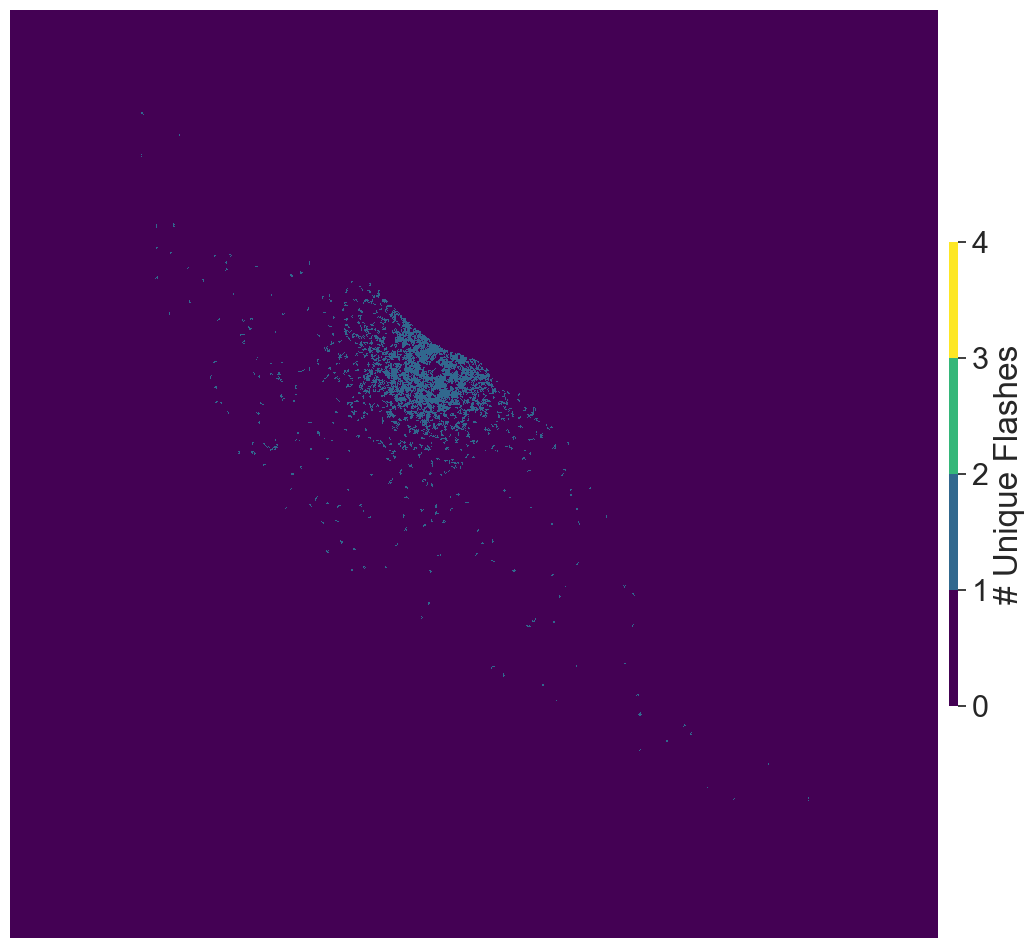

nframes: 50

  mask fname: DUP_2024-02-20 nih hff - glass GCaMP8s.lif - Series023 cell8 - 4m5s bottom _MASKcellfill-15
	masked image shape: 1200 x 1200
	masked cell size (num pixels): 305598

  Cell-wide Brightness:
		Mean: 1.86, Median: 1.85, StdDev: 0.021
  Cell-wide Fractional Variance:
		0.000246


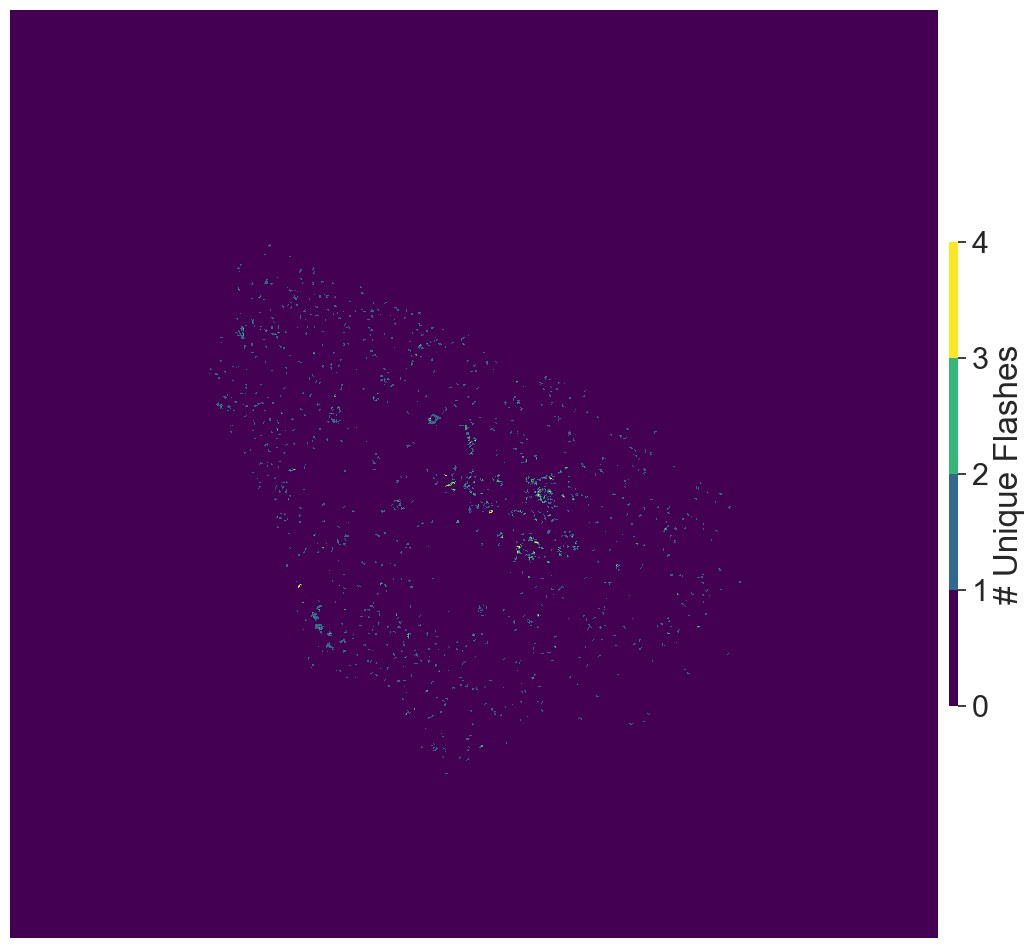

nframes: 73

  mask fname: DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series032 cell11 _MASKcellfill-15
	masked image shape: 596 x 1192
	masked cell size (num pixels): 190359

  Cell-wide Brightness:
		Mean: 11.80, Median: 11.80, StdDev: 0.130
  Cell-wide Fractional Variance:
		0.001437


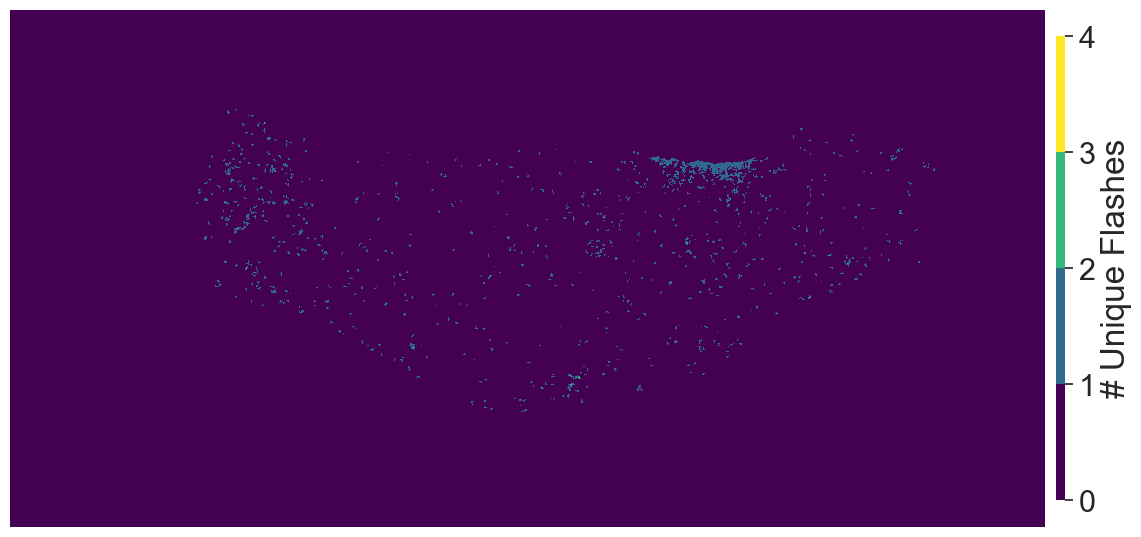

nframes: 33

  mask fname: DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series034 cell11 (slice1-33) _MASKcellfill-15
	masked image shape: 596 x 1192
	masked cell size (num pixels): 173916

  Cell-wide Brightness:
		Mean: 10.49, Median: 10.49, StdDev: 0.075
  Cell-wide Fractional Variance:
		0.000536


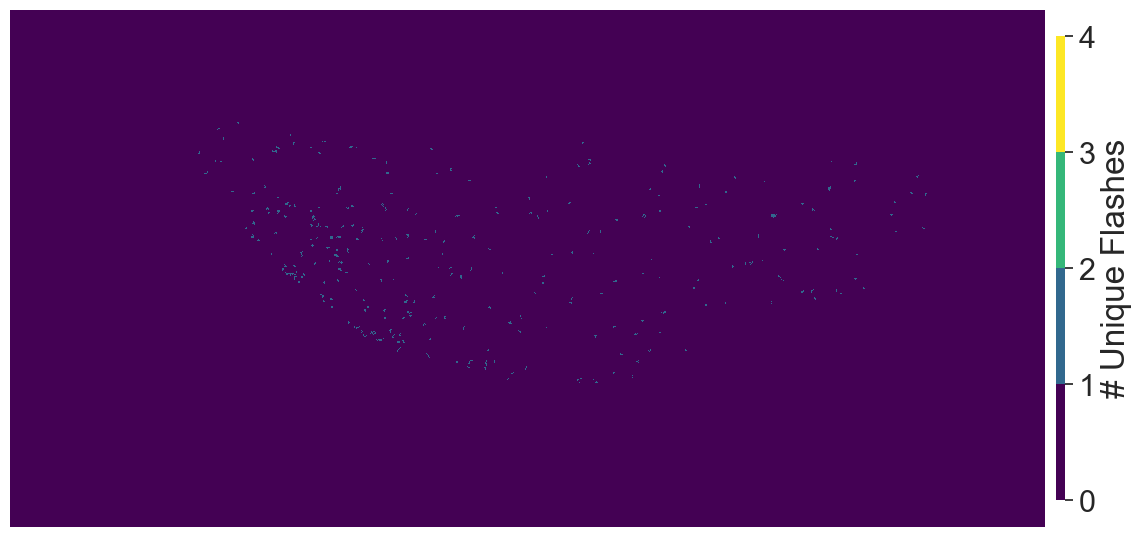

nframes: 49

  mask fname: DUP_2024-01-30 nih hff - cdm GCaMP8s PLATE2.lif - Series012 cell3 - upper _MASKcellfill-15
	masked image shape: 1088 x 1088
	masked cell size (num pixels): 210725

  Cell-wide Brightness:
		Mean: 19.46, Median: 19.41, StdDev: 0.168
  Cell-wide Fractional Variance:
		0.001447


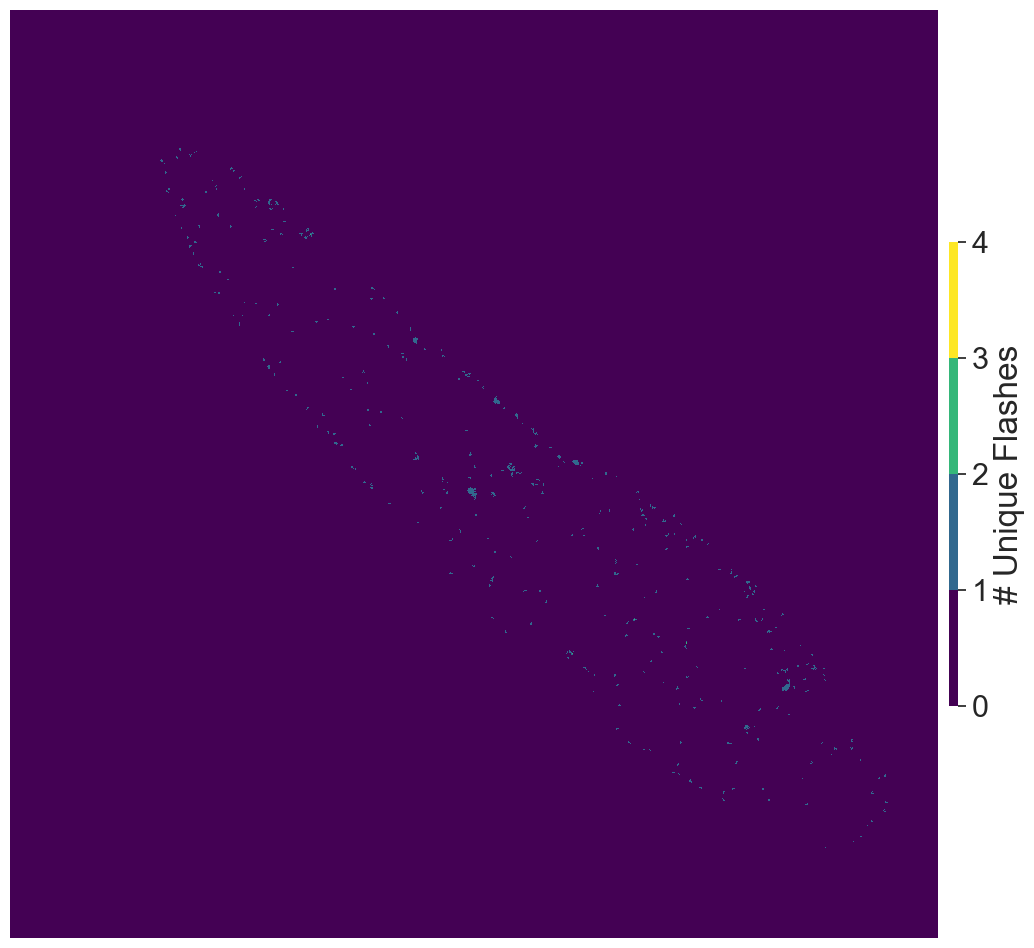

nframes: 54

  mask fname: DUP_2024-05-01 nih hff - cdm EGFPc1 3ug.lif - Series008 cell4 - 5m5s (frame1-54) _MASKcellfill-15
	masked image shape: 952 x 952
	masked cell size (num pixels): 65749

  Cell-wide Brightness:
		Mean: 31.12, Median: 31.17, StdDev: 0.133
  Cell-wide Fractional Variance:
		0.000571


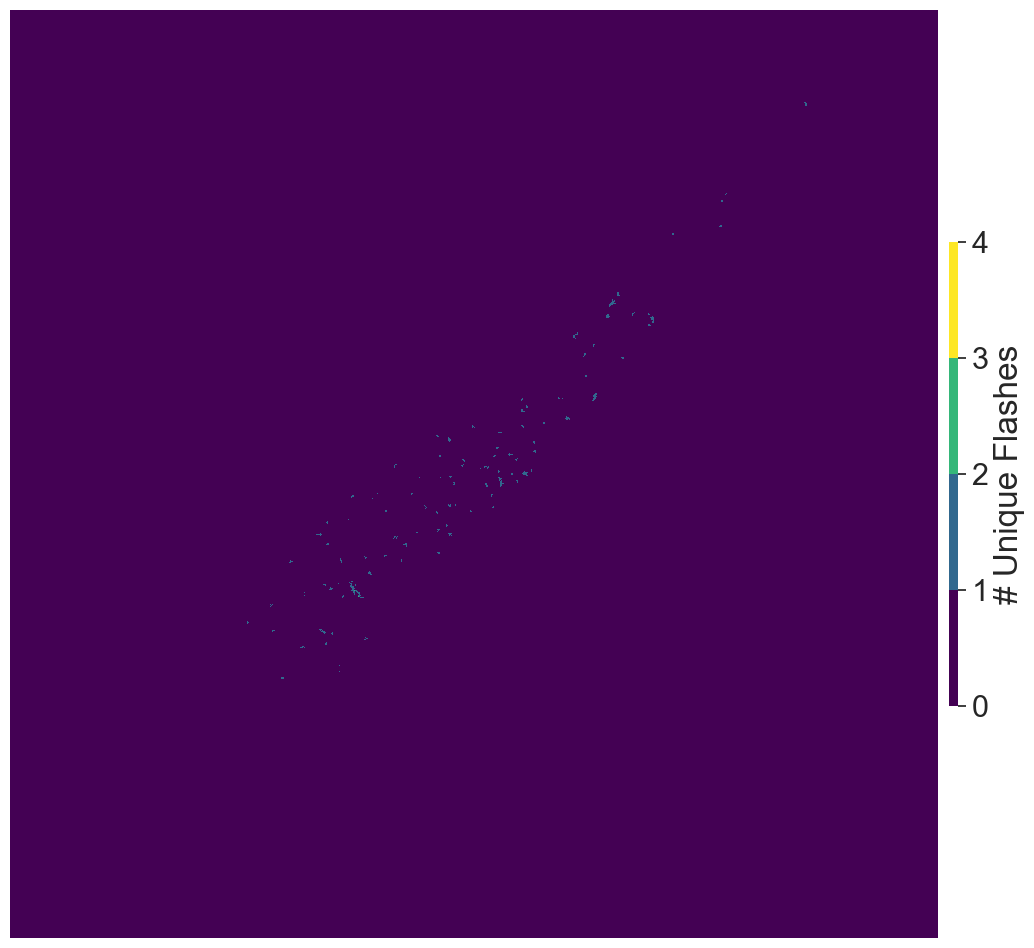

In [5]:
import matplotlib.patches as patches
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

#===========================
#===========================
# Sample Data
#===========================
#===========================
# control:
# DUP_2024-05-01 nih hff - cdm EGFPc1 3ug.lif - Series008 cell4 - 5m5s (frame1-54)

# 2d glass data:
# DUP_2024-01-30 nih hff - glass GCaMP8s.lif - Series004 8bit
# DUP_2024-02-20 nih hff - glass GCaMP8s.lif - Series023 cell8 - 4m5s bottom
# DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series032 cell11
# DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series034 cell11 (slice1-33)

# 3d matrix data:
# DUP_2024-01-30 nih hff - cdm GCaMP8s PLATE2.lif - Series012 cell3 - upper

#=================================
#=================================
# Sample Data Filename locations
#=================================
#=================================
fnames = ["Sample_Data/Videos/DUP_2024-01-30 nih hff - glass GCaMP8s.lif - Series004 8bit.tif",\
          "Sample_Data/Videos/DUP_2024-02-20 nih hff - glass GCaMP8s.lif - Series023 cell8 - 4m5s bottom.tif",\
          "Sample_Data/Videos/DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series032 cell11.tif",\
          "Sample_Data/Videos/DUP_2024-07-22 nih hff - glass GCaMP8s 3ug.lif - Series034 cell11 (slice1-33).tif",\
          "Sample_Data/Videos/DUP_2024-01-30 nih hff - cdm GCaMP8s PLATE2.lif - Series012 cell3 - upper.tif",\
          "Sample_Data/Videos/DUP_2024-05-01 nih hff - cdm EGFPc1 3ug.lif - Series008 cell4 - 5m5s (frame1-54).tif"]

dtypes = ["2D", "2D", "2D", "2D", "3D", "Control"]

#=================================
#=================================
# Loop through files
#=================================
#=================================
for (filename, dtype) in zip(fnames, dtypes):
    
    #================ Get base name from filename ==================#
    fname_start = 19
    fname_end = -4
    fname = filename[fname_start: fname_end]
    
    
    #================ Read in video file & get meta details ==================#    
    img = io.imread(filename) # for reading the TIF files
    nframes = img.shape[0]
    print('nframes:', nframes)
    width = img.shape[1]
    height = img.shape[2]
    spacing, yResolution, xResolution = read_tiff_voxel_size(filename)
    
    
    #================ Process video file, remove background ==================#    
    filtt = ndimage.median_filter(img, size=3)
    filtt_no_bg, filtt_only_bg = isolate_cell(filtt)
         
        
    #================ Read in corresponding FIJI Mask files ==================#    
    mask_filename = "Sample_Data/Masks/%s _MASKcellfill-15.tif" %(fname)
    mask_fname = mask_filename[18:-4]
    
            
    #================ Apply the mask to the video file ==================#    
    result, cell_size = apply_mask_from_file(filtt_no_bg, mask_filename, filename_shorthand=mask_fname)

    
    #================ Compute Num Unique Flashes at each Pixel Location ==================#    
    freqs_img_three = freq_of_flashes(result, nstd=3.0)
    
            
    #================ Compute Cell-wide Mean/Median/Std and Variance ==================#    
    tot_mean, tot_median, tot_std, tot_var = compute_total_img_stats(result)
    print('\n  Cell-wide Brightness:\n\t\tMean: %0.2f, Median: %0.2f, StdDev: %0.3f' %(tot_mean, tot_median, tot_std))
    print('  Cell-wide Fractional Variance:\n\t\t%0.6f' %(tot_var/tot_median))

    
    #================ Create colors and colormap for Plotting ==================#    
    # Make colors for heatmap
    cmap = plt.cm.inferno  # define the colormap
    # extract all colors from the .inferno map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.arange(0, 5, 1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    
    #================ Heatmap of Number of Unique Flashes ==================#    
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(12,10))  
    im = sns.heatmap(freqs_img_three, ax=ax, square=True, cmap="viridis", norm=norm, vmax=5,
                     cbar_kws={'pad':0.01, 'aspect':50, 'label':'# Unique Flashes', 'fraction':0.046, 'shrink':0.5}) 
    plt.xticks(ticks=[], labels=[])
    plt.yticks(ticks=[], labels=[])
    plt.tight_layout()
    
    plt.savefig("Figures/%s_UniqueFlashes_3sig.png" %fname)
    plt.show()
    